In [1]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import trange

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from function.conserve import Entropy
from function.seqfilter import SeqFilter
from function.conserve import ConservePeraa
from function.utilities import get_taxid_dict
from function.utilities import get_protein_name
from function.utilities import get_uniprot_rawdata
from function.utilities import find_human_sequence

# Param

In [2]:
#####CHANGE HERE#####
uniprot_id = "Q13148"
algorithm = "VSL2" #VLXT, VSL2, VL3-BA
#####CHANGE HERE#####

In [3]:
tax_ids = [7711, 7742, 32523, 40674]

input_path = Path("./output/fasta/d_extre_filtered")
output_path = Path("./output/fig2_conservation")

disorder_filter_length = 40
order_filter_length = 10

conserve_peraa_sort = ["A","C","D","E","G","H","I","K","L","M","N","P","Q","R","S","T","V","F","W","Y",]

# Load uniprot and PONDR identified data

In [4]:
human_uniprot_path = Path("./rawdata/human_uniprot.tab")
human_df = get_uniprot_rawdata(human_uniprot_path)

pondr_disorder_ident_path = Path("./output/pondr_disorder_ident")
od_human_df = pd.read_pickle(pondr_disorder_ident_path / "{}_od_human_df.pkl".format(algorithm))

# Conservation level

In [5]:
def get_only_human_score(score, fasta_path):
    """
    get entropy score only when alignment positions on human sequence is not gap

    score: list, entropy score calculated by Entropy().alied_entropy()
    fasta_path: str, fasta file 
    
    return: list, score as same length with human sequence
    """
    nogap_score = []
    nogap = np.array(list(find_human_sequence(fasta_path)["sequence"])) != "-"
    nogap_index = np.where(nogap)[0].tolist()
    for index in nogap_index:
        nogap_score.append(score[index])
    return nogap_score


def get_conserve_score(tax_id, uniprot_id):
    """
    get conserve score and order/disorder region info
    
    tax_id: int, taxonomy id, i.e. 7711
    uniprot_id: str, uniprot id
    
    return: dict, conserve score with other infos
    """

    # read fasta
    fasta_path = input_path / str(tax_id) / "{}.fasta".format(uniprot_id)

    # get conserve score
    # source Capra JA and Singh M. Predicting functionally important residues from sequence conservation.
    #        Bioinformatics, 23(15):1875-82, 2007. [Bioinformatics]
    #        https://compbio.cs.princeton.edu/conservation/   
    conserve_score = entropy.alied_entropy(fasta_path)

    # only nogap conserve_score
    conserve_score = get_only_human_score(conserve_score, fasta_path)

    # get order/disorder region
    od_ident = od_human_df[od_human_df["uniprot_id"] == uniprot_id]["od_ident"].values[0]  
    od_ident = seqfilter.length_filter_by_od_ident(od_ident, disorder_filter_length, order_filter_length)

    # score and od_ident length error handle, 
    # due to different sequence record between OMA and uniprot but uniprot_id are same
    if len(conserve_score) != len(od_ident):
        print("{} ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT".format(uniprot_id))
        raise Exception("error")

    # human_sequence remove gaps from alied fasta file
    human_sequence = find_human_sequence(fasta_path)["sequence"]
    human_sequence = human_sequence.replace("-", "")

    # get region after remove gaps
    region = seqfilter.get_od_index(od_ident)

    # get infos
    taxonomy = get_taxid_dict()[tax_id]
    gene_name = get_protein_name(uniprot_id, human_df)["gene_name"]

    return {
        "uniprot_id": uniprot_id,
        "gene_name": gene_name,
        "taxonomy": taxonomy,
        "score": conserve_score,
        "od_ident": od_ident,
        "human_sequence": human_sequence,
        "region": region,
    }

In [6]:
entropy = Entropy()
seqfilter = SeqFilter()

conserve_list = []

t = trange(len(tax_ids), leave=True)
for i in t:
    t.set_description(str(tax_ids[i]))
    t.refresh()

    conserve = get_conserve_score(tax_id=tax_ids[i], uniprot_id=uniprot_id)
    conserve_list.append(conserve)

  0%|          | 0/4 [00:00<?, ?it/s]

### Conservation level output

In [7]:
conservation_level_output_path = output_path / Path("level")
conservation_level_output_path = conservation_level_output_path/ "{}_{}_{}_level.xlsx".format(conserve_list[0]["uniprot_id"], conserve_list[0]["gene_name"],algorithm)
conservation_level_output_path

PosixPath('output/fig2_conservation/level/Q13148_TARDBP_VSL2_level.xlsx')

In [8]:
df = pd.DataFrame()

for tax in conserve_list:
    df_single = pd.DataFrame()
    taxonomy = tax["taxonomy"]
    df_single[taxonomy] = tax["score"]
    df = pd.concat([df, df_single], axis=1)

df["od"] = list(conserve_list[0]["od_ident"])
df["sequence"] = list(conserve_list[0]["human_sequence"])

df.to_excel(conservation_level_output_path)

# Conservation peraa

In [9]:
def get_conserve_peraa_score(uniprot_id):
    """
    get conserve score per amino acid
    
    uniprot_id: str, uniprot id
    
    return: dict, conserve score with other infos
    """
    
    # array's dim: 2(aa content/peraa conserve), 2(order/disorder), 20(A, C, D, E), 4(taxonomy id)
    peraa_score = np.zeros((2, 2, 20, len(tax_ids)))
    
    taxonomy_list = []
    for tax_index, tax_id in enumerate(tax_ids):

        # read fasta
        fasta_path = input_path / str(tax_id) / "{}.fasta".format(uniprot_id)

        # get order/disorder region
        od_ident = od_human_df[od_human_df["uniprot_id"] == uniprot_id]["od_ident"].values[0]  
        od_ident = seqfilter.length_filter_by_od_ident(od_ident, disorder_filter_length, order_filter_length)  
        od_ident = seqfilter.od_add_alignment(fasta_path, od_ident)  # od_ident alied with fasta file

        # get conserve score and aa content
        info_dict = conserveperaa.get_aa_info(fasta_path, od_ident)
        order_conserve, order_content = (info_dict["conserve"]["order"], info_dict["content"]["order"])
        disorder_conserve, disorder_content = (info_dict["conserve"]["disorder"], info_dict["content"]["disorder"])

        # put into array
        for aa_index, element in enumerate(conserve_peraa_sort):
            peraa_score[0][0][aa_index][tax_index] = order_content[element]
            peraa_score[0][1][aa_index][tax_index] = disorder_content[element]
            peraa_score[1][0][aa_index][tax_index] = order_conserve[element]
            peraa_score[1][1][aa_index][tax_index] = disorder_conserve[element]

        # get infos
        taxonomy = get_taxid_dict()[tax_id]
        taxonomy_list.append(taxonomy)
        gene_name = get_protein_name(uniprot_id, human_df)["gene_name"]

    return {
        "uniprot_id": uniprot_id,
        "gene_name": gene_name,
        "taxonomy": taxonomy_list,
        "conserve_peraa_sort": conserve_peraa_sort,
        "peraa_score": peraa_score,
    }

In [10]:
conserveperaa = ConservePeraa()
conserve_peraa = get_conserve_peraa_score(uniprot_id)

### Conservation peraa output

In [11]:
conservation_peraa_output_path = output_path / Path("peraa")
conservation_peraa_output_path = conservation_peraa_output_path / "{}_{}_{}_peraa.xlsx".format(conserve_peraa["uniprot_id"], conserve_peraa["gene_name"],algorithm)
conservation_peraa_output_path

PosixPath('output/fig2_conservation/peraa/Q13148_TARDBP_VSL2_peraa.xlsx')

In [12]:
d_peraa = pd.DataFrame(conserve_peraa["peraa_score"][1][1], columns=conserve_peraa["taxonomy"], index=conserve_peraa_sort)
d_peraa["content"] = conserve_peraa["peraa_score"][0][1][:, 0]
d_peraa.to_excel(conservation_peraa_output_path)

# Plot

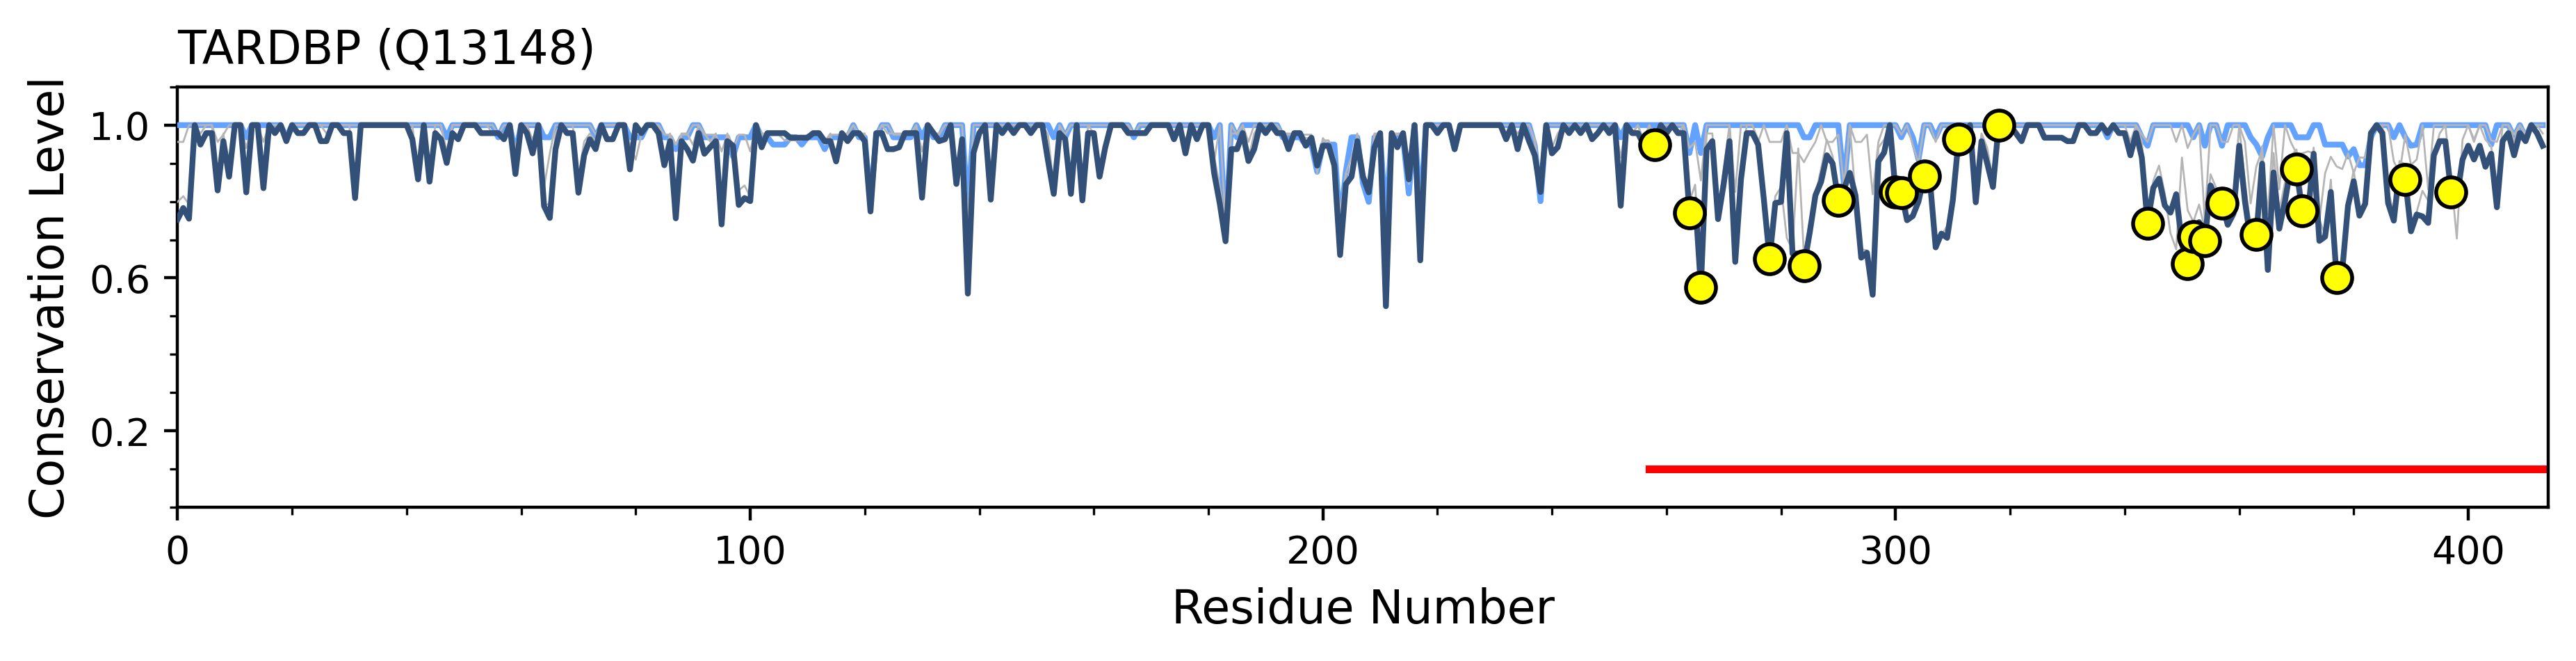

In [13]:
f, (a0) = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(11, 2), dpi=400)

for i in conserve_list:

    # line
    if i["taxonomy"] == "chordata":
        a0.plot(i["score"], color="#335079", zorder=100, linewidth=1.5)
    elif i["taxonomy"] == "vertebrata":
        a0.plot(i["score"], color="#b5b5b5", zorder=75, linewidth=0.5)
    elif i["taxonomy"] == "tetrapoda":
        a0.plot(i["score"], color="#b5b5b5", zorder=50, linewidth=0.5)
    elif i["taxonomy"] == "mammalia":
        a0.plot(i["score"], color="#63a2fe", zorder=25, linewidth=1.5)

    a0.set_xlim(0, len(i["score"]))
    a0.xaxis.set_major_locator(MultipleLocator(100))
    a0.xaxis.set_minor_locator(MultipleLocator(20))

    a0.yaxis.set_major_locator(MultipleLocator(0.4))
    a0.yaxis.set_minor_locator(MultipleLocator(0.1))
    a0.set_yticks(np.arange(0.2, 1.2, 0.4))
    a0.set_ylim(0, 1.1)

    title = "{} ({})".format(conserve_list[0]["gene_name"], conserve_list[0]["uniprot_id"], fontsize=12)
    a0.set_title(title, loc="left")
    a0.set_xlabel("Residue Number", fontsize=12)
    a0.set_ylabel("Conservation Level", fontsize=12)

for region in conserve_list[0]["region"]["disorder_region"]:
    start = region["start"]
    start = start / len(conserve_list[0]["human_sequence"])
    end = region["end"]
    end = end / len(conserve_list[0]["human_sequence"])
    a0.axhline(0.1, start, end, color="#ff0000", linewidth=2)

# WYF point
for index, (od, aa, score) in enumerate(
    zip(conserve_list[0]["od_ident"], conserve_list[0]["human_sequence"], conserve_list[0]["score"])):
    if od == "1":
#         if aa == "Y":
#             a0.scatter(index, score, s=60, color="#ffff00", edgecolors="black", zorder=200)
#         elif aa == "F":
#             a0.scatter(index, score, s=60, color="#ffa300", edgecolors="black", zorder=200)
#         elif aa == "W":
#             a0.scatter(index, score, s=60, color="#9400d1", edgecolors="black", zorder=200)
        if aa == "N":
            a0.scatter(index, score, s=60, color="#ffff00", edgecolors="black", zorder=200)

Text(0.16, 1.2, 'HNRNPD (Q14103)')

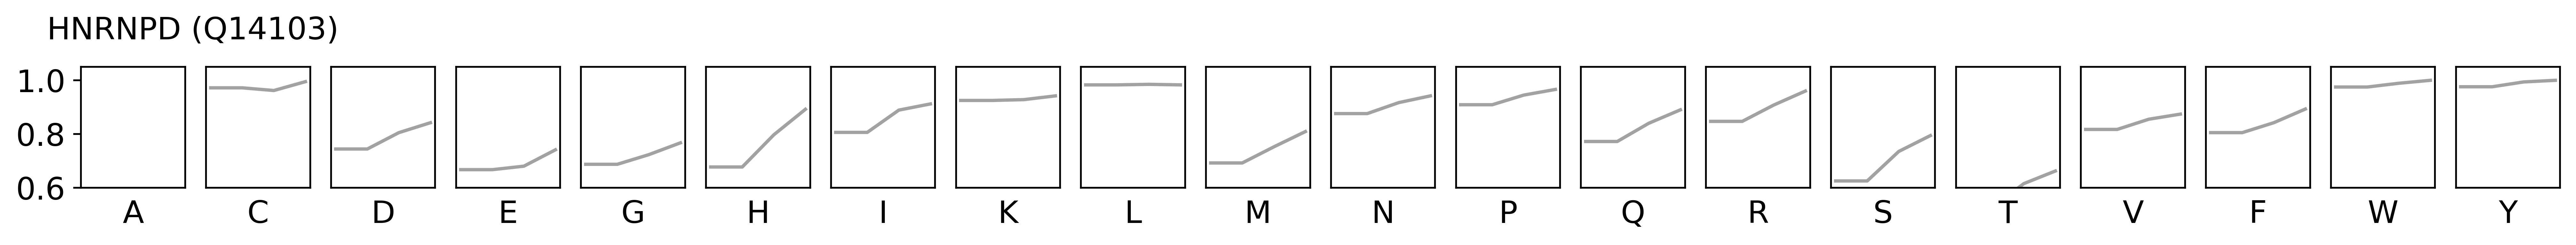

In [72]:
f, (disorder) = plt.subplots(1, 20, sharex=True, sharey=True, figsize=(20, 1), dpi=500)

for index, sub in enumerate(disorder):
    sub.plot(conserve_peraa["peraa_score"][1][1][index], linestyle="solid", color="#a2a2a2")
    sub.set_title(conserve_peraa["conserve_peraa_sort"][index], y=-0.4, fontsize=14)
    sub.set_ylim(0.65, 1.05)
    sub.set_yticks(np.arange(0.6, 1.05, 0.2))
    sub.get_xaxis().set_visible(False)
    sub.tick_params(axis="y", labelsize=14)
    if index != 0:
        sub.get_yaxis().set_visible(False)

title = "{} ({})".format(conserve_peraa["gene_name"], conserve_peraa["uniprot_id"], fontsize=12)
f.suptitle(title, x=0.16, y=1.2, fontsize=14)